In [68]:
import pandas as pd
import numpy as np

# Visualizations
import seaborn as sns
sns.set_style("dark")
sns.set(style="darkgrid", color_codes=True)

import matplotlib.pyplot as plt

# Preparation
from sklearn.model_selection import train_test_split

# Cross Validation
from sklearn.model_selection import cross_val_score

# Possible Models
from sklearn.ensemble import RandomForestClassifier

# Optimize Random Forest 
from sklearn.model_selection import GridSearchCV


# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# optuna.logging.set_verbosity(optuna.logging.ERROR)

In [69]:
# Import the training data
training_path = "train.csv"
training_df = pd.read_csv(training_path)

# Import the test data
testing_path =  "test.csv"
test_df = pd.read_csv(testing_path)

In [70]:
import re
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name) # Find a word between a space and with a .(dot) after
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

def bin_fare(row):
    if row['Fare'] < 30:
        row['Cheap'] = 1
        row['Medium'] = 0
        row['Expensive'] = 0

    elif row['Fare'] < 100:
        row['Cheap'] = 0
        row['Medium'] = 1
        row['Expensive'] = 0

    else:
        row['Cheap'] = 0
        row['Medium'] = 0
        row['Expensive'] = 1
    
    return row

In [71]:
training_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [72]:
# Data conversion

# ********************* Cleanup actions *********************
def cleanup_df(input_df):
    input_data = input_df.copy()

    # ***** Age Features
    input_data["Age"].fillna(28, inplace=True) # mean age imputation

    # Bin Age
    input_data.loc[ input_data['Age'] <= 16, 'Age'] = 0
    input_data.loc[(input_data['Age'] > 16) & (input_data['Age'] <= 32), 'Age'] = 1
    input_data.loc[(input_data['Age'] > 32) & (input_data['Age'] <= 48), 'Age'] = 2
    input_data.loc[(input_data['Age'] > 48) & (input_data['Age'] <= 64), 'Age'] = 3
    input_data.loc[ input_data['Age'] > 64, 'Age']

    # Handle embarked
    input_data["Embarked"].fillna("S", inplace=True)
    input_data = pd.get_dummies(input_data, prefix=['Embarked'], columns=['Embarked'], drop_first=True)

    # ***** Family Features
    # Let's simplify the family situation
    input_data['family_c'] = input_data['SibSp'] + input_data['Parch']
    input_data['alone'] = np.where(input_data['family_c'] == 0, 1, 0)
    input_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)

    # ***** Title Feature
    # Create a new feature Title, containing the titles of passenger names
    input_data['Title'] = input_data['Name'].apply(get_title)
    #Categorize titles
    input_data['Title'] = input_data['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    input_data['Title'] = input_data['Title'].replace('Mlle', 'Miss')
    input_data['Title'] = input_data['Title'].replace('Ms', 'Miss')
    input_data['Title'] = input_data['Title'].replace('Mme', 'Mrs')
    # Mapping titles
    input_data = pd.get_dummies(input_data, prefix=['Title'], columns=['Title'], drop_first=True)

    # Map Sex
    input_data['Sex'] = input_data['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

    # Handle Cabin
    input_data['Has_Cabin'] = input_data["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

    # Drop Name and Ticket
    input_data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

    # Fill the missing Fare
    input_data["Fare"].fillna(32.20, inplace=True) # mean fare
    # Bin Fares
    input_data.loc[ input_data['Fare'] <= 7.91, 'Fare'] = 0
    input_data.loc[(input_data['Fare'] > 7.91) & (input_data['Fare'] <= 14.454), 'Fare'] = 1
    input_data.loc[(input_data['Fare'] > 14.454) & (input_data['Fare'] <= 31), 'Fare']   = 2
    input_data.loc[ input_data['Fare'] > 31, 'Fare'] = 3

    #remove the passsengerID column
    input_passengers = input_data['PassengerId']
    input_data.drop('PassengerId', axis=1, inplace=True)

    return input_data, input_passengers

In [73]:
train_data, _ = cleanup_df(training_df)
train_data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked_Q,Embarked_S,family_c,alone,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Has_Cabin
0,0,3,0,1.0,0.0,0,1,1,0,0,1,0,0,0
1,1,1,1,2.0,3.0,0,0,1,0,0,0,1,0,1
2,1,3,1,1.0,1.0,0,1,0,1,1,0,0,0,0
3,1,1,1,2.0,3.0,0,1,1,0,0,0,1,0,1
4,0,3,0,2.0,1.0,0,1,0,1,0,1,0,0,0


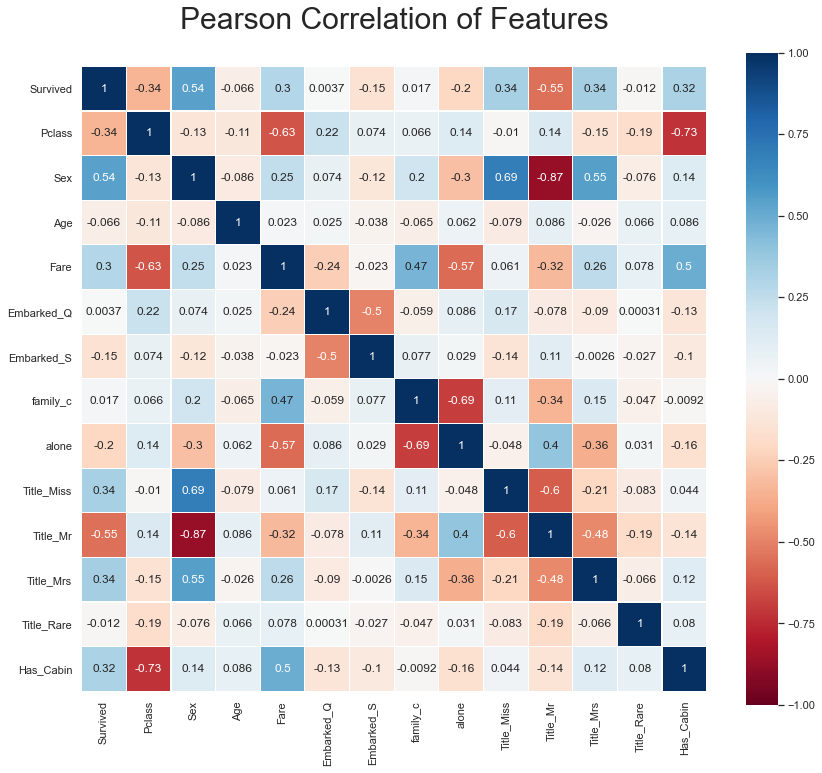

In [74]:
colormap = plt.cm.RdBu

plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', size=30, y=1.05)

sns.heatmap(train_data.astype(float).corr(),
linewidths=0.1,
vmax=1.0, 
vmin=-1,
square=True, 
cmap=colormap, 
linecolor='white', 
annot=True)

plt.show()

# Model Training

In [75]:
y = train_data['Survived'] #target variable
X = train_data.drop('Survived', axis=1)

In [76]:
# Train / Validation split
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [77]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': range(3, 11),
    'n_estimators': range(10, 300, 10),
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [78]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [79]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

Fitting 3 folds for each of 232 candidates, totalling 696 fits


{'max_depth': 6, 'n_estimators': 70}

In [80]:
# RFC
rfc = RandomForestClassifier(n_estimators=70, max_depth=6)
rfc.fit(X, y)

# Score model (cross validation)
scores = cross_val_score(rfc, X, y, cv=5, scoring='accuracy')

score = sum(scores)/len(scores)
score

0.822666499278137

In [82]:
test_data, test_passengers = cleanup_df(test_df)

In [83]:
# Predictions = RFC
rfc_preds = rfc.predict(test_data)

# Create submission csv - RFC
output_rfc = pd.DataFrame({'PassengerId': test_passengers.astype(int),
                       'Survived': rfc_preds.astype(int)})
output_rfc.set_index('PassengerId')
output_rfc.to_csv('submission_rfc_2.csv', index=False)